<a href="https://colab.research.google.com/github/tc-neurodriguez/MT_Pericam/blob/master/20260126MTPericam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

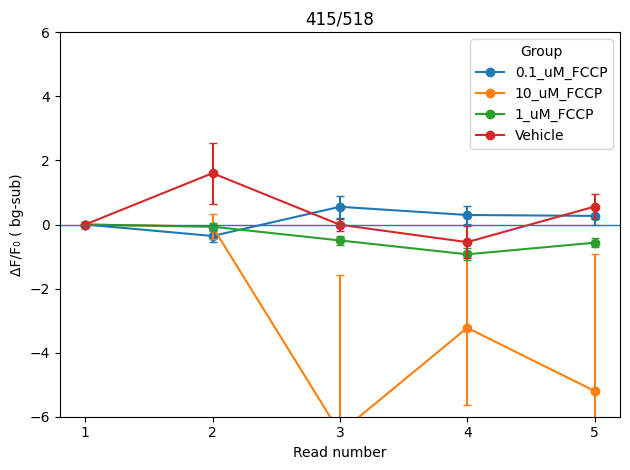

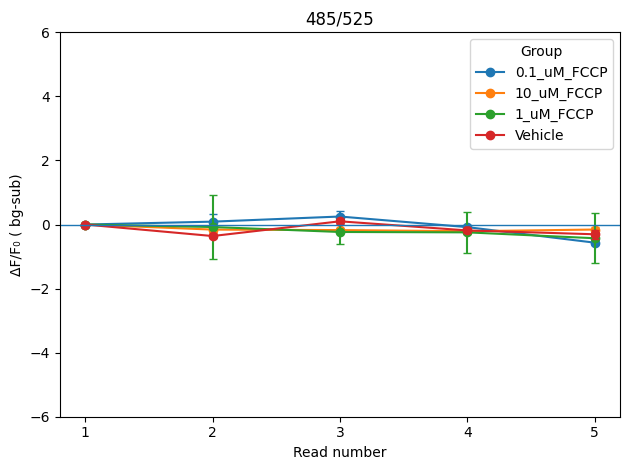

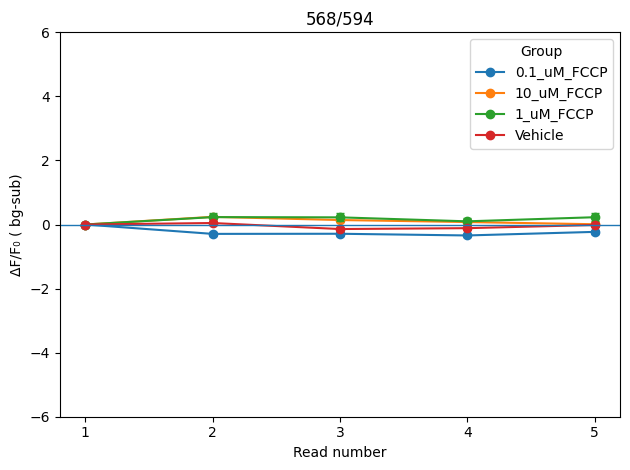

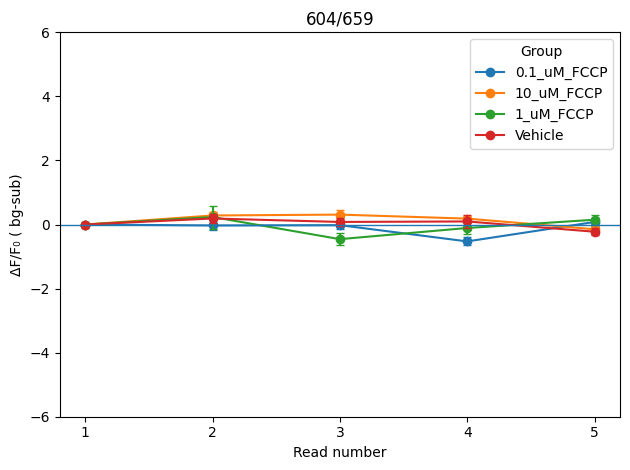

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from __future__ import annotations
from collections import defaultdict
from typing import Dict, List, Optional, Tuple
from openpyxl import load_workbook

file_path = r"/content/2026mtpclonec5sy5yfccpsweep.xlsx"
wells = ['A1','A2','A3','A4','A5','A6','A7','A8', 'A9', 'A10', 'A11','A12',
         'B1','B2','B3','B4','B5','B6','B7','B8', 'B9', 'B10', 'B11','B12',
         'C1','C2','C3','C4','C5','C6','C7','C8', 'C9', 'C10', 'C11','C12',
         'D1','D2','D3','D4','D5','D6','D7','D8', 'D9', 'D10', 'D11','D12',
         'E1','E2','E3','E4','E5','E6','E7','E8', 'E9', 'E10', 'E11','E12',
         'F1','F2','F3','F4','F5','F6','F7','F8', 'F9', 'F10', 'F11','F12',
         'G1','G2','G3','G4','G5','G6','G7','G8', 'G9', 'G10', 'G11','G12',
         'H1','H2','H3','H4','H5','H6','H7','H8', 'H9', 'H10', 'H11','H12']





def excel_plate_text_to_groups(
    xlsx_path: str,
    sheet_name: str,
    top_left: str,
    bottom_right: str,
    empty_labels: Tuple[str, ...] = ("", None, "NA", "N/A"),
    row_labels: List[str] = list("ABCDEFGH"),
    strip_whitespace: bool = True,
) -> Tuple[List[str], Dict[str, str], Dict[str, List[str]]]:
    """
    Read an 8x12 (96-well) region from Excel where each cell contains a text label
    (e.g., 'Vehicle', '0.1_uM_FCCP'). Returns:

      wells:         ['A1', 'A2', ... 'H12']
      well_to_group: {'A1': 'Vehicle', ...}
      groups:        {'Vehicle': ['A1','A2',...], '0.1_uM_FCCP': [...], ...}

    Assumes the region is ordered left-to-right columns 1..12 and top-to-bottom rows A..H.
    """
    wb = load_workbook(xlsx_path, data_only=True)
    ws = wb[sheet_name]

    region = ws[top_left:bottom_right]

    n_rows = len(region)
    n_cols = len(region[0]) if n_rows else 0
    if n_rows != 8 or n_cols != 12:
        # not fatal, but warn via exception for plate consistency
        raise ValueError(f"Expected an 8x12 region, got {n_rows}x{n_cols}. Check top_left/bottom_right.")

    wells: List[str] = []
    well_to_group: Dict[str, str] = {}
    groups: Dict[str, List[str]] = defaultdict(list)

    for r_idx, row in enumerate(region, start=1):
        row_letter = row_labels[r_idx - 1]
        for c_idx, cell in enumerate(row, start=1):
            well = f"{row_letter}{c_idx}"  # A1..H12 (no zero padding)
            wells.append(well)

            val = cell.value
            if strip_whitespace and isinstance(val, str):
                val = val.strip()

            if val in empty_labels:
                # skip empty/unassigned wells
                continue

            label = str(val)
            well_to_group[well] = label
            groups[label].append(well)

    return wells, well_to_group, dict(groups)

# -----------------------
# Example usage
# -----------------------
if __name__ == "__main__":
  xlsx_path = r"/content/Experimental_Groups_20260116.xlsx"
  sheet_name = "Sheet1"

    # Adjust to the exact 8x12 block that contains your plate labels
  top_left = "E4"
  bottom_right = "P11"

  wells, well_to_group, groups = excel_plate_text_to_groups(
      xlsx_path=xlsx_path,
      sheet_name=sheet_name,
      top_left=top_left,
      bottom_right=bottom_right,
  )

  print("wells[0:5] =", wells[:5])
  print("A1 label =", well_to_group.get("A1"))
  print("groups keys =", sorted(groups.keys()))
  print(groups)
  print("Vehicle wells =", groups.get("Vehicle", []))

import string

import re
from typing import Dict, Tuple, List, Optional

import pandas as pd


READ_RE = re.compile(r"^\s*Read\s*(\d+)\s*:\s*(\d+)\s*,\s*(\d+)\s*$")
WELL_RE = re.compile(r"^[A-H](?:[1-9]|1[0-2])$")


def _is_blank(x) -> bool:
    if x is None:
        return True
    if isinstance(x, float) and pd.isna(x):
        return True
    if isinstance(x, str) and x.strip() == "":
        return True
    return False


def _find_read_cells(raw: pd.DataFrame) -> List[Tuple[int, int, str]]:
    """Return list of (row, col, label) for each cell that looks like 'Read N:ex,em'."""
    found = []
    for r in range(raw.shape[0]):
        for c in range(raw.shape[1]):
            v = raw.iat[r, c]
            if isinstance(v, str) and READ_RE.match(v.strip()):
                found.append((r, c, v.strip()))
    return found


def _locate_header_row(raw: pd.DataFrame, start_r: int) -> Tuple[int, int]:
    """
    From a 'Read ...' line, search downward for a row containing:
      - a 'Time' cell
      - and at least one well header like 'A1'
    Return (header_row_index, time_col_index).
    """
    for rr in range(start_r + 1, min(start_r + 30, raw.shape[0])):
        row_vals = [raw.iat[rr, cc] for cc in range(raw.shape[1])]

        time_col = None
        for cc, v in enumerate(row_vals):
            if isinstance(v, str) and v.strip() == "Time":
                time_col = cc
                break

        if time_col is None:
            continue

        has_well = any(isinstance(x, str) and WELL_RE.match(x.strip()) for x in row_vals)
        if has_well:
            return rr, time_col

    raise ValueError(f"Couldn't locate header row below read block starting at row {start_r}.")


def _extract_block(raw: pd.DataFrame, read_label: str, read_r: int) -> pd.DataFrame:
    """
    Parse one block into a wide dataframe with columns:
    Time, Temp_C (if present), A1, A2, ...
    """
    header_row, time_col = _locate_header_row(raw, read_r)

    # Determine header span starting at time_col until first empty header after we've started
    colnames = []
    col_indices = []
    for cc in range(time_col, raw.shape[1]):
        v = raw.iat[header_row, cc]
        if _is_blank(v):
            if colnames:
                break
            continue
        colnames.append(str(v).strip())
        col_indices.append(cc)

    data_start = header_row + 1

    rows = []
    for rr in range(data_start, raw.shape[0]):
        first = raw.iat[rr, time_col]

        # stop if next read block begins
        if isinstance(first, str) and READ_RE.match(first.strip()):
            break

        # stop if time column blank
        if _is_blank(first):
            break

        rows.append([raw.iat[rr, cc] for cc in col_indices])

    df = pd.DataFrame(rows, columns=colnames)


    # Add parsed read metadata
    m = READ_RE.match(read_label.strip())
    read_num, ex, em = (None, None, None)
    if m:
        read_num, ex, em = m.group(1), m.group(2), m.group(3)

    df.insert(0, "read_label", read_label.strip())
    df.insert(1, "read_num", int(read_num) if read_num is not None else None)
    df.insert(2, "ex_nm", int(ex) if ex is not None else None)
    df.insert(3, "em_nm", int(em) if em is not None else None)

    return df


def parse_all_reads(
    xlsx_path: str,
    sheet_name: str | int = 0,
    first_row_only: bool = False,
) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    Parse every 'Read ...' block on the sheet.

    Returns:
      long_df: tidy dataframe with columns
        read_label, read_num, ex_nm, em_nm, Time, Temp_C (optional), well, value
      blocks: dict mapping read_label -> wide block dataframe
    """
    raw = pd.read_excel(xlsx_path, sheet_name=sheet_name, header=None, dtype=object)

    read_cells = _find_read_cells(raw)
    if not read_cells:
        raise ValueError("No 'Read N:ex,em' blocks found in this sheet.")

    # Parse each block
    blocks: Dict[str, pd.DataFrame] = {}
    for r, c, label in read_cells:
        # Avoid duplicates if label appears more than once
        if label in blocks:
            continue
        blocks[label] = _extract_block(raw, label, r)

    # Convert each wide block to long tidy format
    long_parts = []
    for label, wide in blocks.items():
        w = wide.copy()

        if first_row_only:
            w = w.iloc[[0]].copy()

        meta_cols = ["read_label", "read_num", "ex_nm", "em_nm"]
        id_vars = meta_cols + [c for c in ["Time",] if c in w.columns]

        # Identify well columns: A1..H12
        well_cols = [c for c in w.columns if isinstance(c, str) and WELL_RE.match(c.strip())]
        if not well_cols:
            # If the export used A01 style or extra spaces, try a looser match:
            well_cols = []
            for c in w.columns:
                if isinstance(c, str):
                    s = c.strip()
                    s2 = re.sub(r"^([A-H])0?(\d{1,2})$", r"\1\2", s)  # A01 -> A1
                    if WELL_RE.match(s2):
                        well_cols.append(c)

        long = w.melt(
            id_vars=id_vars,
            value_vars=well_cols,
            var_name="well",
            value_name="value",
        )

        # Normalize well names (A01 -> A1)
        long["well"] = long["well"].astype(str).str.strip()
        long["well"] = long["well"].str.replace(r"^([A-H])0?(\d{1,2})$", r"\1\2", regex=True)

        long_parts.append(long)

    long_df = pd.concat(long_parts, ignore_index=True)

    # Optional: sort nicely
    sort_cols = [c for c in ["read_num", "ex_nm", "em_nm", "Time", "well"] if c in long_df.columns]
    if sort_cols:
        long_df = long_df.sort_values(sort_cols).reset_index(drop=True)

    return long_df, blocks
# ---- Example usage ----
import pandas as pd

# Parse reads
long_df, blocks = parse_all_reads(file_path, sheet_name=0, first_row_only=True)

# Attach group from plate map
long_df["group"] = long_df["well"].map(well_to_group)
# ---- Define which wells are "EMPTY background wells" ----
# Prefer: use the group label AND col 12 (so you don’t accidentally use other EMPTY wells)
# Ensure numeric fluorescence
df2 = long_df.copy()
df2["value"] = pd.to_numeric(df2["value"], errors="coerce")
df2 = df2.dropna(subset=["value"])
# Parse row letter and column number from well (supports A1 or A01)
m = df2["well"].astype(str).str.strip().str.extract(r"^([A-H])0?(\d{1,2})$")
df2["row"] = m[0]
df2["col"] = m[1].astype(float).astype("Int64")
df2 = df2.dropna(subset=["row", "col"])
EMPTY_GROUP_NAME = "empty"
empty_bg_mask = df2["group"].astype(str).str.upper() == EMPTY_GROUP_NAME.upper()


# ---- 1) Row-wise background: mean of EMPTY wells in column 12 for each row ----
bg = (
    df2[empty_bg_mask]
    .groupby(["ex_nm", "em_nm", "read_num", "row"], as_index=False)
    .agg(bg_row=("value", "mean"))
)
bg_global = (
    df2[empty_bg_mask]
    .groupby(["ex_nm", "em_nm", "read_num"], as_index=False)
    .agg(bg_mean=("value", "mean"), bg_sd=("value", "std"), bg_n=("value", "count"))
)
df_bs = df2.merge(bg_global, on=["ex_nm", "em_nm", "read_num"], how="left")
df_bs["F_bgsub_global"] = df_bs["value"] - df_bs["bg_mean"]

# Merge background onto all wells (same wavelength + read + row)
df_bs2 = df_bs.merge(bg, on=["ex_nm", "em_nm", "read_num", "row"], how="left")
# Background-subtracted fluorescence per well
df_bs2["F_bgsub"] = df_bs2["value"] - df_bs2["bg_row"]
#######################################

bg = (
    df_bs2[df_bs2["group"].astype(str).str.lower().eq("empty")]
    .groupby(["ex_nm","em_nm","read_num"], as_index=False)
    .agg(bg_mean=("value","mean"), bg_sd=("value","std"))
)

bg["wavelength"] = bg["ex_nm"].astype(int).astype(str) + "/" + bg["em_nm"].astype(int).astype(str)

for wl, d in bg.groupby("wavelength", sort=True):
    plt.figure()
    d = d.sort_values("read_num")
    line, = plt.plot(d["read_num"], d["bg_mean"], marker="o")
    plt.errorbar(d["read_num"], d["bg_mean"], yerr=d["bg_sd"], fmt="none", capsize=3, color=line.get_color())
    plt.title(f"EMPTY background vs read — {wl}")
    plt.xlabel("Read number")
    plt.ylabel("Mean EMPTY fluorescence")
    plt.xticks(sorted(d["read_num"].unique()))
    plt.tight_layout()
    plt.show()










#####################################
df = df_bs2[df_bs2["group"].astype(str).str.lower() != "empty"].copy()

df_g = (
    df.groupby(["ex_nm","em_nm","group","read_num"], as_index=False)
      .agg(
          bg_row=("F_bgsub","mean"),
          bgsub_mean=("F_bgsub_global","mean"),
      )
)

df_g["wavelength"] = df_g["ex_nm"].astype(int).astype(str) + "/" + df_g["em_nm"].astype(int).astype(str)

for wl, d_wl in df_g.groupby("wavelength", sort=True):
    plt.figure()
    for group, d_grp in d_wl.groupby("group", sort=True):
        d_grp = d_grp.sort_values("read_num")
        plt.plot(d_grp["read_num"], d_grp["bg_row"], marker="o", label=f"{group} bgrow")
        plt.plot(d_grp["read_num"], d_grp["bgsub_mean"], marker="o", linestyle="--", label=f"{group} bgsub")

    plt.xlabel("Read number")
    plt.ylabel("Mean fluorescence")
    plt.title(f"{wl} global bg-sub")
    plt.xticks(sorted(d_wl["read_num"].unique()))
    plt.legend()
    plt.tight_layout()
    plt.show()

##############################F0#######################
# --- 2) Per-well F0 (baseline): read 1, after row background subtraction ---
# ---- Keep EMPTY as a group in df_bs, but create a non-empty view for downstream signal ----
# Keep EMPTY as group in df_bs2, but remove EMPTY rows for signal calculations
df_bs_nonempty = df_bs2[~empty_bg_mask].copy()

# Keep EMPTY as group in df_bs2, but remove EMPTY rows for signal calculations
df_bs_nonempty = df_bs2[~empty_bg_mask].copy()

# Baseline per (well, ex/em) at read 1
F0 = (
    df_bs_nonempty[df_bs_nonempty["read_num"] == 1]
    .loc[:, ["ex_nm", "em_nm", "well", "F_bgsub_global"]]
    .rename(columns={"F_bgsub_global": "F0"})
    .drop_duplicates(subset=["ex_nm", "em_nm", "well"])
)

# Merge baseline back onto all non-empty signal rows
df_dff = df_bs_nonempty.merge(F0, on=["ex_nm", "em_nm", "well"], how="left")

# Safety check
if df_dff["F0"].isna().any():
    bad = df_dff.loc[df_dff["F0"].isna(), ["ex_nm","em_nm","well"]].drop_duplicates()
    raise ValueError(f"Missing F0 for some wells/wavelengths:\n{bad}")

eps = 1e-12
df_dff["FF0"] = df_dff["F_bgsub_global"] / (df_dff["F0"] + eps)

import matplotlib.pyplot as plt

# Requires df_dff["group"] to exist. If not, map it first like before:
# df_dff["group"] = df_dff["well"].map(well_to_group)
df_plot = df_dff.copy()
df_plot["wavelength"] = df_plot["ex_nm"].astype(int).astype(str) + "/" + df_plot["em_nm"].astype(int).astype(str)

import numpy as np

df_grp = (
    df_plot
    .groupby(["wavelength", "group", "read_num"], as_index=False)
    .agg(
        mean_ff=("FF0", "mean"),
        sd_ff=("FF0", "std"),
        n=("FF0", "count"),
    )
)

df_grp["sem_ff"] = df_grp["sd_ff"] / np.sqrt(df_grp["n"])
for wl, d_wl in df_grp.groupby("wavelength", sort=True):
    plt.figure()

    for g, d_g in d_wl.groupby("group", sort=True):
        d_g = d_g.sort_values("read_num")

        # Plot line + markers, capture the line object
        line, = plt.plot(
            d_g["read_num"],
            d_g["mean_ff"],
            marker="o",
            label=g
        )

        # Reuse the exact same color for error bars
        plt.errorbar(
            d_g["read_num"],
            d_g["mean_ff"],
            yerr=d_g["sem_ff"],
            capsize=3,
            color=line.get_color(),      # 🔑 key line
            fmt="none"                   # no extra markers
        )

    plt.axhline(0, linewidth=1)
    plt.xlabel("Read number")
    plt.ylabel("F/F₀ (mean ± SEM)")
    plt.title(f"{wl}")
    plt.xticks(sorted(d_wl["read_num"].unique()))
    plt.ylim(0, 2)
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()



    ##############################################RAW
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# NO background subtraction version (use raw "value")
# -------------------------------------------------------

# Remove EMPTY wells from downstream signal calculations (but keep them in df_bs2 if you want)
df_raw_nonempty = df_bs2[~empty_bg_mask].copy()

# Ensure numeric
df_raw_nonempty["value"] = pd.to_numeric(df_raw_nonempty["value"], errors="coerce")
df_raw_nonempty = df_raw_nonempty.dropna(subset=["value"])

# Baseline per (well, ex/em) at read 1 using RAW fluorescence
F0_raw = (
    df_raw_nonempty[df_raw_nonempty["read_num"] == 1]
    .loc[:, ["ex_nm", "em_nm", "well", "value"]]
    .rename(columns={"value": "F0_raw"})
    .drop_duplicates(subset=["ex_nm", "em_nm", "well"])
)

# Merge baseline back onto all non-empty signal rows
df_ff0_raw = df_raw_nonempty.merge(F0_raw, on=["ex_nm", "em_nm", "well"], how="left")

# Compute F/F0 (raw)
eps = 1e-12
df_ff0_raw["FF0_raw"] = df_ff0_raw["value"] / (df_ff0_raw["F0_raw"] + eps)

# Plot prep
df_plot = df_ff0_raw.copy()
df_plot["wavelength"] = df_plot["ex_nm"].astype(int).astype(str) + "/" + df_plot["em_nm"].astype(int).astype(str)

df_grp = (
    df_plot
    .groupby(["wavelength", "group", "read_num"], as_index=False)
    .agg(
        mean_ff=("FF0_raw", "mean"),
        sd_ff=("FF0_raw", "std"),
        n=("FF0_raw", "count"),
    )
)

df_grp["sem_ff"] = df_grp["sd_ff"] / np.sqrt(df_grp["n"])

# Plot
for wl, d_wl in df_grp.groupby("wavelength", sort=True):
    plt.figure()

    for g, d_g in d_wl.groupby("group", sort=True):
        d_g = d_g.sort_values("read_num")

        line, = plt.plot(
            d_g["read_num"],
            d_g["mean_ff"],
            marker="o",
            label=g
        )

        plt.errorbar(
            d_g["read_num"],
            d_g["mean_ff"],
            yerr=d_g["sem_ff"],
            capsize=3,
            color=line.get_color(),
            fmt="none"
        )

    plt.xlabel("Read number")
    plt.ylabel("Raw F/F₀ (mean ± SEM)")
    plt.title(f"{wl} (no background subtraction)")
    plt.xticks(sorted(d_wl["read_num"].unique()))
    plt.ylim(0, 2)   # adjust if needed
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------
# All wells (no background subtraction)
# ΔF/F0 using raw "value"
# ---------------------------------------

df_nonempty = df_bs2[~empty_bg_mask].copy()

# numeric
df_nonempty["F_bgsub"] = pd.to_numeric(df_nonempty["F_bgsub"], errors="coerce")
df_nonempty = df_nonempty.dropna(subset=["F_bgsub"])

# (Optional) exclude column 12 from signal plots (common if it's EMPTY wells)
if "col" not in df_nonempty.columns:
    df_nonempty["col"] = df_nonempty["well"].astype(str).str.extract(r"(\d+)").astype(int)
df_nonempty = df_nonempty[df_nonempty["col"] != 12].copy()

# Baseline F0 per well per wavelength at read 1 (raw)
F0_raw = (
    df_nonempty[df_nonempty["read_num"] == 1]
    .loc[:, ["ex_nm", "em_nm", "well", "F_bgsub"]]
    .rename(columns={"F_bgsub": "F0"})
    .drop_duplicates(subset=["ex_nm", "em_nm", "well"])
)

df_dff = df_nonempty.merge(F0_raw, on=["ex_nm", "em_nm", "well"], how="left")

# Safety check
if df_dff["F0"].isna().any():
    bad = df_dff.loc[df_dff["F0"].isna(), ["ex_nm","em_nm","well"]].drop_duplicates()
    raise ValueError(f"Missing F0 (Read 1) for some wells:\n{bad}")

eps = 1e-12
df_dff["dFF0"] = (df_dff["F_bgsub"] - df_dff["F0"]) / (df_dff["F0"] + eps)

# wavelength label
df_dff["wavelength"] = df_dff["ex_nm"].astype(int).astype(str) + "/" + df_dff["em_nm"].astype(int).astype(str)

# group summary (mean ± SEM)
df_grp = (
    df_dff
    .groupby(["wavelength", "group", "read_num"], as_index=False)
    .agg(
        mean_dff=("dFF0", "mean"),
        sd_dff=("dFF0", "std"),
        n=("dFF0", "count"),
    )
)
df_grp["sem_dff"] = df_grp["sd_dff"] / np.sqrt(df_grp["n"])

# plot
for wl, d_wl in df_grp.groupby("wavelength", sort=True):
    plt.figure()

    for g, d_g in d_wl.groupby("group", sort=True):
        d_g = d_g.sort_values("read_num")

        line, = plt.plot(d_g["read_num"], d_g["mean_dff"], marker="o", label=g)
        plt.errorbar(
            d_g["read_num"], d_g["mean_dff"],
            yerr=d_g["sem_dff"],
            capsize=3,
            color=line.get_color(),
            fmt="none"
        )

    plt.axhline(0, linewidth=1)
    plt.xlabel("Read number")
    plt.ylabel("ΔF/F₀ ( bg-sub)")
    plt.title(f"{wl}")
    plt.xticks(sorted(d_wl["read_num"].unique()))
    plt.ylim(-6, 6)
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()



In [ ]:
cols = ["well", "group", "value", "ex_nm", "em_nm", "read_num", "F_bgsub", "F0", "dFF0"]
df_dff.loc[df_dff["group"] == "10_uM_FCCP", cols]



,well,group,value,ex_nm,em_nm,read_num,F_bgsub,F0,dFF0
55,F1,10_uM_FCCP,3846,415,518,1,262.0,262.0,0.000000
56,F10,10_uM_FCCP,3842,415,518,1,258.0,258.0,0.000000
57,F11,10_uM_FCCP,3893,415,518,1,309.0,309.0,0.000000
58,F2,10_uM_FCCP,3576,415,518,1,-8.0,-8.0,-0.000000
59,F3,10_uM_FCCP,3570,415,518,1,-14.0,-14.0,-0.000000
60,F4,10_uM_FCCP,3862,415,518,1,278.0,278.0,0.000000
61,F5,10_uM_FCCP,3759,415,518,1,175.0,175.0,0.000000
62,F6,10_uM_FCCP,4052,415,518,1,468.0,468.0,0.000000
63,F7,10_uM_FCCP,3984,415,518,1,400.0,400.0,0.000000
64,F8,10_uM_FCCP,4208,415,518,1,624.0,624.0,0.000000
